In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import ast
from utils_deepcog import compute_local_nr2

# Define the main directories
main_dir = '../../../../oracle-data/serly/Scalable_dnn/MAE_plots/DeepCOG_miMo_vs_MiMo/cvs'
lstm_dir = '../../../../oracle-data/serly/Scalable_dnn/MAE_plots/DeepCOG_miMo_vs_MiMo/cvs/LSTM/'

# Parameters to iterate over
cities = ['Milan']  # List of cities to iterate over
random_flags = ['False']  # Random flag variations
Ks = [2, 3, 4, 5, 6, 10, 15, 20]
nr2_values = [2, 3, 4, 5, 6, 7]
nr = 21

# Initialize a variable to keep track of the maximum MAE value
max_total_cost = 0  # Initialize maximum total cost
data = {}  # Dictionary to store the data

# First pass: Collect data and compute max_total_cost
for city in cities:
    for random_flag in random_flags:
        for nr2 in nr2_values:
            # Initialize data structures for this combination
            data_key = (city, random_flag, nr2)
            data[data_key] = {
                'total_costs_miMo': {},
                'total_costs_original': {},
                'total_costs_lstm': {},
                'total_costs_miMo_retrained': {}
            }

            # Create dictionaries to store total costs for each K
            total_costs_miMo = {}
            total_costs_original = {}
            total_costs_lstm = {}
            total_costs_miMo_retrained = {}

            # Loop over each K and each cluster_label to process CSV files
            for K in Ks:
                # Initialize sums for each K
                total_costs_miMo[K] = 0
                total_costs_original[K] = 0
                total_costs_lstm[K] = 0
                total_costs_miMo_retrained[K] = 0

                # Iterate over each cluster label (0 to K-1)
                for cluster_label in range(K):
                    # Compute local_nr2
                    local_nr2 = compute_local_nr2(K, nr2, city, nr, cluster_label)

                    # Paths to CSV files
                    csv_path_main = os.path.join(main_dir, f'{city}/{random_flag}/')
                    csv_file = os.path.join(
                        csv_path_main, f'costs_comparison_K_{K}_{cluster_label}_size_{local_nr2}.csv')
                    csv_file_lstm = os.path.join(
                        lstm_dir, f'{city}/{random_flag}/costs_lstm_K_{K}_{cluster_label}_size_{local_nr2}.csv')
                    csv_path_miMo_retrained = os.path.join(main_dir, f'retrained_mimo/{city}/')
                    csv_file_miMo_retrained = os.path.join(
                        csv_path_miMo_retrained, f'costs_comparison_K_{K}_{cluster_label}_size_{local_nr2}.csv')

                    # Check if files exist
                    if not os.path.exists(csv_file):
                        print(f"File not found: {csv_file}")
                        continue
                    if not os.path.exists(csv_file_lstm):
                        print(f"File not found: {csv_file_lstm}")
                        continue
                    if not os.path.exists(csv_file_miMo_retrained):
                        print(f"File not found: {csv_file_miMo_retrained}")
                        continue

                    # Load the CSV data
                    df = pd.read_csv(csv_file)
                    if df.empty:
                        print(f"CSV file is empty: {csv_file}")
                        continue
                    df_lstm = pd.read_csv(csv_file_lstm)
                    if df_lstm.empty:
                        print(f"CSV file is empty: {csv_file_lstm}")
                        continue
                    df_retrained = pd.read_csv(csv_file_miMo_retrained)
                    if df_retrained.empty:
                        print(f"CSV file is empty: {csv_file_miMo_retrained}")
                        continue

                    # Process df (costs_miMo and costs_original)
                    for idx, row in df.iterrows():
                        try:
                            costs_miMo = row['costs_miMo']
                            costs_original = row['costs_original']
                       # Ensure it is a float
                            if not isinstance(costs_miMo, (int, float)):
                                costs_miMo = float(costs_miMo)
                            if not isinstance(costs_original, (int, float)):
                                costs_original = float(costs_original)
                            # Summing total costs
                            total_costs_miMo[K] += costs_miMo
                            total_costs_original[K] += costs_original
                        except (SyntaxError, ValueError, IndexError, TypeError) as e:
                            print(f"Error parsing row {idx} in file {csv_file}: {e}")
                            continue

                    # Process df_lstm (costs_siMo)
                    for idx, row in df_lstm.iterrows():
                        try:
                            costs_lstm = ast.literal_eval(row['costs_siMo'])

                            # Summing total costs
                            total_costs_lstm[K] += costs_lstm[0]
                        except (SyntaxError, ValueError, IndexError, TypeError) as e:
                            print(f"Error parsing row {idx} in file {csv_file_lstm}: {e}")
                            continue

                    # Process df_retrained (costs_miMo)
                    for idx, row in df_retrained.iterrows():
                        try:
                            # Directly handle raw numbers or cast to float
                            costs_miMo_retrained = row['costs_miMo']
                            
                            # Ensure it is a float
                            if not isinstance(costs_miMo_retrained, (int, float)):
                                costs_miMo_retrained = float(costs_miMo_retrained)

                            # Add to total costs
                            total_costs_miMo_retrained[K] += costs_miMo_retrained

                        except (ValueError, TypeError) as e:
                            print(f"Error parsing row {idx} in file {csv_file_miMo_retrained}: {e}")
                            continue


                # Update the maximum total cost
                max_total_cost = max(
                    max_total_cost,
                    total_costs_miMo[K],
                    total_costs_original[K],
                    total_costs_lstm[K],
                    total_costs_miMo_retrained[K]
                )

                # Store the total costs in the data dictionary
                data[data_key]['total_costs_miMo'][K] = total_costs_miMo[K]
                data[data_key]['total_costs_original'][K] = total_costs_original[K]
                data[data_key]['total_costs_lstm'][K] = total_costs_lstm[K]
                data[data_key]['total_costs_miMo_retrained'][K] = total_costs_miMo_retrained[K]

# Second pass: Generate the plots with the same y-axis scale
for city in cities:
    for random_flag in random_flags:
        for nr2 in nr2_values:
            data_key = (city, random_flag, nr2)
            total_costs_miMo = data[data_key]['total_costs_miMo']
            total_costs_original = data[data_key]['total_costs_original']
            total_costs_lstm = data[data_key]['total_costs_lstm']
            total_costs_miMo_retrained = data[data_key]['total_costs_miMo_retrained']
            # Fixed value for total_costs_lstm_per_bs
            total_costs_lstm_per_bs = 7.84e+03

            # Plotting the data for the current nr2
            fig, ax1 = plt.subplots(figsize=(3, 2))

            # X-axis positions for the bars
            x = np.arange(len(Ks))

            # Plotting total cost as bars
            width = 0.2  # Adjusted width to fit four bars
            miMo_values = [total_costs_miMo[K] for K in Ks]
            original_values = [total_costs_original[K] for K in Ks]
            lstm_values = [total_costs_lstm[K] for K in Ks]
            miMo_retrained_values = [total_costs_miMo_retrained[K] for K in Ks]

            ax1.bar(x - 1.5*width, miMo_retrained_values, width=width, alpha=0.8, color='purple', label='miMo 3D-CNN with LRP')
            ax1.bar(x - 0.5*width, miMo_values, width=width, alpha=0.5, color='blue', label='miMo 3D-CNN centroid')
            # ax1.bar(x + 0.5*width, original_values, width=width, alpha=0.5, color='green', label='Global 3D-CNN')
            ax1.bar(x + 0.5*width, lstm_values, width=width, alpha=0.5, color='red', label='LSTM')
            # Plotting the Global 3D-CNN as a horizontal line
            ax1.hlines(original_values, xmin=-0.5, xmax=len(Ks) - 0.5, colors='green', alpha=0.1, linestyles='solid', label='Global 3D-CNN')
            # Add the new horizontal line for total_costs_lstm_per_bs
            ax1.hlines(total_costs_lstm_per_bs, xmin=-0.5, xmax=len(Ks) - 0.5, colors='black', linestyles='solid', label=f'LSTM per BS')
            ax1.set_xlabel('K', fontsize=8)
            ax1.set_ylabel('Total MAE', fontsize=8)
            ax1.set_xticks(x)
            ax1.set_xticklabels(Ks, fontsize=8)
            ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

            # For Milan
            if city == 'Milan':
                offset_x = -0.10
                offset_y = -0.1
            else:
                offset_x = -0.13
                offset_y = -0.5
            ax1.yaxis.get_offset_text().set_position((offset_x, 0))  # Move 1e10 to the left of '3' on y-axis

            # # # Manually adjust the offset text using a transformed translation
            offset_text = ax1.yaxis.get_offset_text()
            transform = offset_text.get_transform()
            offset_text.set_transform(transform + plt.matplotlib.transforms.ScaledTranslation(0, offset_y, fig.dpi_scale_trans))  # Move down
            offset_text.set_fontsize(7) 
            ax1.xaxis.set_label_coords(0.98, -0.06)  # Moves K more to the right and slightly up

            for label in ax1.get_yticklabels():
                label.set_fontsize(8)
            # ax1.legend(loc='best', fontsize=18)

            # Set y-axis limit to the maximum total cost
            ax1.set_ylim(0, max_total_cost * 1.1)  # Multiply by 1.1 for some headroom

            # Set title and layout
            # plt.title(f'Comparison:\nCity={city}, Random={random_flag},\nNumber of inputs for models={nr2 * nr2}*K')
            plt.tight_layout()

            # Create plot directory if it doesn't exist
            plot_dir = os.path.join(main_dir, f'comparison_barplots/{city}/all_combined')
            if not os.path.exists(plot_dir):
                os.makedirs(plot_dir)

            # Save the plot
            save_path = os.path.join(plot_dir, f'barplot_{city}_{random_flag}_grid_{nr2}.pdf')
            plt.savefig(save_path, bbox_inches='tight')
            plt.close()


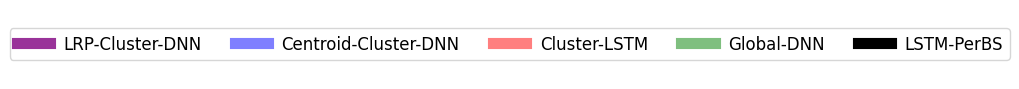

In [70]:
import matplotlib.pyplot as plt

# Create a blank figure for the legend
fig_legend = plt.figure(figsize=(3, 1))
ax = fig_legend.add_subplot(111)

# Define the legend handles and labels
handles = [
    plt.Line2D([0], [0], color='purple', lw=8, alpha=0.8, label='LRP-Cluster-DNN'),
    plt.Line2D([0], [0], color='blue', lw=8, alpha=0.5, label='Centroid-Cluster-DNN'),
        plt.Line2D([0], [0], color='red', lw=8, alpha=0.5, label='Cluster-LSTM'),
    plt.Line2D([0], [0], color='green', lw=8, alpha=0.5, label='Global-DNN'),
    plt.Line2D([0], [0], color='black', lw=8, alpha=1, label='LSTM-PerBS')
]

# Remove axis
ax.axis('off')

# Plot legend
fig_legend.legend(handles=handles, loc='center', fontsize=12, ncol=5)

# Adjust layout and save the legend plot
plt.tight_layout()
plt.savefig('legend_plot.pdf', bbox_inches='tight')
plt.show()



Error value increase

In [ ]:
import os
import pandas as pd
import numpy as np
import csv
import ast
from utils_deepcog import compute_local_nr2

# Define the main directories
main_dir = '../../../../oracle-data/serly/Scalable_dnn/MAE_plots/DeepCOG_miMo_vs_MiMo/cvs'
lstm_dir = '../../../../oracle-data/serly/Scalable_dnn/MAE_plots/DeepCOG_miMo_vs_MiMo/cvs/LSTM/'

# Parameters to iterate over
cities = ['Milan']  # List of cities to iterate over
random_flags = ['False']  # Random flag variations
Ks = [2, 3, 4, 5, 6, 10, 15, 20]
nr2_values = [2, 3, 4, 5, 6, 7]
nr = 21

# Initialize a variable to keep track of the maximum MAE value
max_total_cost = 0  # Initialize maximum total cost
data = {}  # Dictionary to store the data

# First pass: Collect data and compute max_total_cost
for city in cities:
    for random_flag in random_flags:
        for nr2 in nr2_values:
            # Initialize data structures for this combination
            data_key = (city, random_flag, nr2)
            data[data_key] = {
                'total_costs_miMo': {},
                'total_costs_original': {},
                'total_costs_lstm': {},
                'total_costs_miMo_retrained': {}
            }

            # Create dictionaries to store total costs for each K
            total_costs_miMo = {}
            total_costs_original = {}
            total_costs_lstm = {}
            total_costs_miMo_retrained = {}

            # Loop over each K and each cluster_label to process CSV files
            for K in Ks:
                # Initialize sums for each K
                total_costs_miMo[K] = 0
                total_costs_original[K] = 0
                total_costs_lstm[K] = 0
                total_costs_miMo_retrained[K] = 0

                # Iterate over each cluster label (0 to K-1)
                for cluster_label in range(K):
                    # Compute local_nr2
                    local_nr2 = compute_local_nr2(K, nr2, city, nr, cluster_label)

                    # Paths to CSV files
                    csv_path_main = os.path.join(main_dir, f'{city}/{random_flag}/')
                    csv_file = os.path.join(
                        csv_path_main, f'costs_comparison_K_{K}_{cluster_label}_size_{local_nr2}.csv')
                    csv_file_lstm = os.path.join(
                        lstm_dir, f'{city}/{random_flag}/costs_lstm_K_{K}_{cluster_label}_size_{local_nr2}.csv')
                    csv_path_miMo_retrained = os.path.join(main_dir, f'retrained_mimo/{city}/')
                    csv_file_miMo_retrained = os.path.join(
                        csv_path_miMo_retrained, f'costs_comparison_K_{K}_{cluster_label}_size_{local_nr2}.csv')

                    # Check if files exist
                    if not os.path.exists(csv_file):
                        print(f"File not found: {csv_file}")
                        continue
                    if not os.path.exists(csv_file_lstm):
                        print(f"File not found: {csv_file_lstm}")
                        continue
                    if not os.path.exists(csv_file_miMo_retrained):
                        print(f"File not found: {csv_file_miMo_retrained}")
                        continue

                    # Load the CSV data
                    df = pd.read_csv(csv_file)
                    if df.empty:
                        print(f"CSV file is empty: {csv_file}")
                        continue
                    df_lstm = pd.read_csv(csv_file_lstm)
                    if df_lstm.empty:
                        print(f"CSV file is empty: {csv_file_lstm}")
                        continue
                    df_retrained = pd.read_csv(csv_file_miMo_retrained)
                    if df_retrained.empty:
                        print(f"CSV file is empty: {csv_file_miMo_retrained}")
                        continue

                    # Process df (costs_miMo and costs_original)
                    for idx, row in df.iterrows():
                        try:
                            costs_miMo = row['costs_miMo']
                            costs_original = row['costs_original']
                       # Ensure it is a float
                            if not isinstance(costs_miMo, (int, float)):
                                costs_miMo = float(costs_miMo)
                            if not isinstance(costs_original, (int, float)):
                                costs_original = float(costs_original)
                            # Summing total costs
                            total_costs_miMo[K] += costs_miMo
                            total_costs_original[K] += costs_original
                        except (SyntaxError, ValueError, IndexError, TypeError) as e:
                            print(f"Error parsing row {idx} in file {csv_file}: {e}")
                            continue

                    # Process df_lstm (costs_siMo)
                    for idx, row in df_lstm.iterrows():
                        try:
                            costs_lstm = ast.literal_eval(row['costs_siMo'])

                            # Summing total costs
                            total_costs_lstm[K] += costs_lstm[0]
                        except (SyntaxError, ValueError, IndexError, TypeError) as e:
                            print(f"Error parsing row {idx} in file {csv_file_lstm}: {e}")
                            continue

                    # Process df_retrained (costs_miMo)
                    for idx, row in df_retrained.iterrows():
                        try:
                            # Directly handle raw numbers or cast to float
                            costs_miMo_retrained = row['costs_miMo']
                            
                            # Ensure it is a float
                            if not isinstance(costs_miMo_retrained, (int, float)):
                                costs_miMo_retrained = float(costs_miMo_retrained)

                            # Add to total costs
                            total_costs_miMo_retrained[K] += costs_miMo_retrained

                        except (ValueError, TypeError) as e:
                            print(f"Error parsing row {idx} in file {csv_file_miMo_retrained}: {e}")
                            continue

                # Store the total costs in the data dictionary
                data[data_key]['total_costs_miMo'][K] = total_costs_miMo[K]
                data[data_key]['total_costs_original'][K] = total_costs_original[K]
                data[data_key]['total_costs_lstm'][K] = total_costs_lstm[K]
                data[data_key]['total_costs_miMo_retrained'][K] = total_costs_miMo_retrained[K]

# Second pass: Calculate and print the differences
for city in cities:
    for random_flag in random_flags:
        for nr2 in nr2_values:
            data_key = (city, random_flag, nr2)
            total_costs_miMo_retrained = data[data_key]['total_costs_miMo_retrained']
            total_costs_original = data[data_key]['total_costs_original']
            total_costs_miMo = data[data_key]['total_costs_miMo']
            # Print the differences for the current nr2
            print(f"City: {city}, Random Flag: {random_flag}, NR2: {nr2}")
            for K in Ks:
                if K in total_costs_original and K in total_costs_miMo_retrained and K in total_costs_miMo:
                    original_cost = total_costs_original[K]
                    miMo_cost = total_costs_miMo[K]
                    difference = ((miMo_cost - original_cost)/original_cost) * 100
                    print(f"  K={K}: miMo is {difference:.2f}% compared to original")

            print()


City: Milan, Random Flag: False, NR2: 2
  K=2: miMo is 85.01% compared to original
  K=3: miMo is 43.50% compared to original
  K=4: miMo is 39.39% compared to original
  K=5: miMo is 35.73% compared to original
  K=6: miMo is 38.20% compared to original
  K=10: miMo is 22.52% compared to original
  K=15: miMo is 21.88% compared to original
  K=20: miMo is 13.44% compared to original

City: Milan, Random Flag: False, NR2: 3
  K=2: miMo is 55.66% compared to original
  K=3: miMo is 30.31% compared to original
  K=4: miMo is 14.82% compared to original
  K=5: miMo is 25.17% compared to original
  K=6: miMo is 15.95% compared to original
  K=10: miMo is 12.63% compared to original
  K=15: miMo is 3.77% compared to original
  K=20: miMo is -1.43% compared to original

City: Milan, Random Flag: False, NR2: 4
  K=2: miMo is 48.29% compared to original
  K=3: miMo is 14.57% compared to original
  K=4: miMo is 4.65% compared to original
  K=5: miMo is 9.41% compared to original
  K=6: miMo is 

In [ ]:
# Initialize a variable to keep track of the maximum MAE value
max_total_cost = 0  # Initialize maximum total cost
data = {}  # Dictionary to store the data

# First pass: Collect data and compute max_total_cost
for city in cities:
    for random_flag in random_flags:
        for nr2 in nr2_values:
            # Initialize data structures for this combination
            data_key = (city, random_flag, nr2)
            data[data_key] = {
                'total_costs_miMo': {},
                'total_costs_original': {},
                'total_costs_lstm': {},
                'total_costs_miMo_retrained': {}
            }

            # Create dictionaries to store total costs for each K
            total_costs_miMo = {}
            total_costs_original = {}
            total_costs_lstm = {}
            total_costs_miMo_retrained = {}

            # Loop over each K and each cluster_label to process CSV files
            for K in Ks:
                # Initialize sums for each K
                total_costs_miMo[K] = 0
                total_costs_original[K] = 0
                total_costs_lstm[K] = 0
                total_costs_miMo_retrained[K] = 0

                # Iterate over each cluster label (0 to K-1)
                for cluster_label in range(K):
                    # Compute local_nr2
                    local_nr2 = compute_local_nr2(K, nr2, city, nr, cluster_label)

                    # Paths to CSV files
                    csv_path_main = os.path.join(main_dir, f'{city}/{random_flag}/')
                    csv_file = os.path.join(
                        csv_path_main, f'costs_comparison_K_{K}_{cluster_label}_size_{local_nr2}.csv')
                    csv_file_lstm = os.path.join(
                        lstm_dir, f'{city}/{random_flag}/costs_lstm_K_{K}_{cluster_label}_size_{local_nr2}.csv')
                    csv_path_miMo_retrained = os.path.join(main_dir, f'retrained_mimo/{city}/')
                    csv_file_miMo_retrained = os.path.join(
                        csv_path_miMo_retrained, f'costs_comparison_K_{K}_{cluster_label}_size_{local_nr2}.csv')

                    # Check if files exist
                    if not os.path.exists(csv_file):
                        print(f"File not found: {csv_file}")
                        continue
                    if not os.path.exists(csv_file_lstm):
                        print(f"File not found: {csv_file_lstm}")
                        continue
                    if not os.path.exists(csv_file_miMo_retrained):
                        print(f"File not found: {csv_file_miMo_retrained}")
                        continue

                    # Load the CSV data
                    df = pd.read_csv(csv_file)
                    if df.empty:
                        print(f"CSV file is empty: {csv_file}")
                        continue
                    df_lstm = pd.read_csv(csv_file_lstm)
                    if df_lstm.empty:
                        print(f"CSV file is empty: {csv_file_lstm}")
                        continue
                    df_retrained = pd.read_csv(csv_file_miMo_retrained)
                    if df_retrained.empty:
                        print(f"CSV file is empty: {csv_file_miMo_retrained}")
                        continue

                    # Process df (costs_miMo and costs_original)
                    for idx, row in df.iterrows():
                        try:
                            costs_miMo = row['costs_miMo']
                            costs_original = row['costs_original']
                       # Ensure it is a float
                            if not isinstance(costs_miMo, (int, float)):
                                costs_miMo = float(costs_miMo)
                            if not isinstance(costs_original, (int, float)):
                                costs_original = float(costs_original)
                            # Summing total costs
                            total_costs_miMo[K] += costs_miMo
                            total_costs_original[K] += costs_original
                        except (SyntaxError, ValueError, IndexError, TypeError) as e:
                            print(f"Error parsing row {idx} in file {csv_file}: {e}")
                            continue

                    # Process df_lstm (costs_siMo)
                    for idx, row in df_lstm.iterrows():
                        try:
                            costs_lstm = ast.literal_eval(row['costs_siMo'])

                            # Summing total costs
                            total_costs_lstm[K] += costs_lstm[0]
                        except (SyntaxError, ValueError, IndexError, TypeError) as e:
                            print(f"Error parsing row {idx} in file {csv_file_lstm}: {e}")
                            continue

                    # Process df_retrained (costs_miMo)
                    for idx, row in df_retrained.iterrows():
                        try:
                            # Directly handle raw numbers or cast to float
                            costs_miMo_retrained = row['costs_miMo']
                            
                            # Ensure it is a float
                            if not isinstance(costs_miMo_retrained, (int, float)):
                                costs_miMo_retrained = float(costs_miMo_retrained)

                            # Add to total costs
                            total_costs_miMo_retrained[K] += costs_miMo_retrained

                        except (ValueError, TypeError) as e:
                            print(f"Error parsing row {idx} in file {csv_file_miMo_retrained}: {e}")
                            continue

                # Store the total costs in the data dictionary
                data[data_key]['total_costs_miMo'][K] = total_costs_miMo[K]
                data[data_key]['total_costs_original'][K] = total_costs_original[K]
                data[data_key]['total_costs_lstm'][K] = total_costs_lstm[K]
                data[data_key]['total_costs_miMo_retrained'][K] = total_costs_miMo_retrained[K]

# Second pass: Calculate and print the differences
for city in cities:
    for random_flag in random_flags:
        for nr2 in nr2_values:
            data_key = (city, random_flag, nr2)
            total_costs_miMo_retrained = data[data_key]['total_costs_miMo_retrained']
            total_costs_original = data[data_key]['total_costs_original']
            total_costs_miMo = data[data_key]['total_costs_miMo']
            # Print the differences for the current nr2
            print(f"City: {city}, Random Flag: {random_flag}, NR2: {nr2}")
            for K in Ks:
                if K in total_costs_original and K in total_costs_miMo_retrained and K in total_costs_miMo:
                    miMo_enhanced_cost = total_costs_miMo_retrained[K]
                    miMo_cost = total_costs_miMo[K]
                    improved_from_miMo = ((miMo_enhanced_cost - miMo_cost)/miMo_cost) * 100
                    print(f"  K={K}: miMo_enhanced is {improved_from_miMo:.2f}% improved from miMo")
            print()


City: Milan, Random Flag: False, NR2: 2
  K=2: miMo_enhanced is -33.95% improved from miMo
  K=3: miMo_enhanced is -14.46% improved from miMo
  K=4: miMo_enhanced is -15.14% improved from miMo
  K=5: miMo_enhanced is -13.36% improved from miMo
  K=6: miMo_enhanced is -12.56% improved from miMo
  K=10: miMo_enhanced is -7.14% improved from miMo
  K=15: miMo_enhanced is -9.91% improved from miMo
  K=20: miMo_enhanced is -6.04% improved from miMo

City: Milan, Random Flag: False, NR2: 3
  K=2: miMo_enhanced is -23.36% improved from miMo
  K=3: miMo_enhanced is -13.15% improved from miMo
  K=4: miMo_enhanced is -4.22% improved from miMo
  K=5: miMo_enhanced is -10.26% improved from miMo
  K=6: miMo_enhanced is -8.79% improved from miMo
  K=10: miMo_enhanced is -8.91% improved from miMo
  K=15: miMo_enhanced is -4.99% improved from miMo
  K=20: miMo_enhanced is -2.19% improved from miMo

City: Milan, Random Flag: False, NR2: 4
  K=2: miMo_enhanced is -21.10% improved from miMo
  K=3: miMo_e

In [8]:

# Initialize a variable to keep track of the maximum MAE value
max_total_cost = 0  # Initialize maximum total cost
data = {}  # Dictionary to store the data

# First pass: Collect data and compute max_total_cost
for city in cities:
    for random_flag in random_flags:
        for nr2 in nr2_values:
            # Initialize data structures for this combination
            data_key = (city, random_flag, nr2)
            data[data_key] = {
                'total_costs_miMo': {},
                'total_costs_original': {},
                'total_costs_lstm': {},
                'total_costs_miMo_retrained': {}
            }

            # Create dictionaries to store total costs for each K
            total_costs_miMo = {}
            total_costs_original = {}
            total_costs_lstm = {}
            total_costs_miMo_retrained = {}

            # Loop over each K and each cluster_label to process CSV files
            for K in Ks:
                # Initialize sums for each K
                total_costs_miMo[K] = 0
                total_costs_original[K] = 0
                total_costs_lstm[K] = 0
                total_costs_miMo_retrained[K] = 0

                # Iterate over each cluster label (0 to K-1)
                for cluster_label in range(K):
                    # Compute local_nr2
                    local_nr2 = compute_local_nr2(K, nr2, city, nr, cluster_label)

                    # Paths to CSV files
                    csv_path_main = os.path.join(main_dir, f'{city}/{random_flag}/')
                    csv_file = os.path.join(
                        csv_path_main, f'costs_comparison_K_{K}_{cluster_label}_size_{local_nr2}.csv')
                    csv_file_lstm = os.path.join(
                        lstm_dir, f'{city}/{random_flag}/costs_lstm_K_{K}_{cluster_label}_size_{local_nr2}.csv')
                    csv_path_miMo_retrained = os.path.join(main_dir, f'retrained_mimo/{city}/')
                    csv_file_miMo_retrained = os.path.join(
                        csv_path_miMo_retrained, f'costs_comparison_K_{K}_{cluster_label}_size_{local_nr2}.csv')

                    # Check if files exist
                    if not os.path.exists(csv_file):
                        print(f"File not found: {csv_file}")
                        continue
                    if not os.path.exists(csv_file_lstm):
                        print(f"File not found: {csv_file_lstm}")
                        continue
                    if not os.path.exists(csv_file_miMo_retrained):
                        print(f"File not found: {csv_file_miMo_retrained}")
                        continue

                    # Load the CSV data
                    df = pd.read_csv(csv_file)
                    if df.empty:
                        print(f"CSV file is empty: {csv_file}")
                        continue
                    df_lstm = pd.read_csv(csv_file_lstm)
                    if df_lstm.empty:
                        print(f"CSV file is empty: {csv_file_lstm}")
                        continue
                    df_retrained = pd.read_csv(csv_file_miMo_retrained)
                    if df_retrained.empty:
                        print(f"CSV file is empty: {csv_file_miMo_retrained}")
                        continue

                    # Process df (costs_miMo and costs_original)
                    for idx, row in df.iterrows():
                        try:
                            costs_miMo = row['costs_miMo']
                            costs_original = row['costs_original']
                       # Ensure it is a float
                            if not isinstance(costs_miMo, (int, float)):
                                costs_miMo = float(costs_miMo)
                            if not isinstance(costs_original, (int, float)):
                                costs_original = float(costs_original)
                            # Summing total costs
                            total_costs_miMo[K] += costs_miMo
                            total_costs_original[K] += costs_original
                        except (SyntaxError, ValueError, IndexError, TypeError) as e:
                            print(f"Error parsing row {idx} in file {csv_file}: {e}")
                            continue

                    # Process df_lstm (costs_siMo)
                    for idx, row in df_lstm.iterrows():
                        try:
                            costs_lstm = ast.literal_eval(row['costs_siMo'])

                            # Summing total costs
                            total_costs_lstm[K] += costs_lstm[0]
                        except (SyntaxError, ValueError, IndexError, TypeError) as e:
                            print(f"Error parsing row {idx} in file {csv_file_lstm}: {e}")
                            continue

                    # Process df_retrained (costs_miMo)
                    for idx, row in df_retrained.iterrows():
                        try:
                            # Directly handle raw numbers or cast to float
                            costs_miMo_retrained = row['costs_miMo']
                            
                            # Ensure it is a float
                            if not isinstance(costs_miMo_retrained, (int, float)):
                                costs_miMo_retrained = float(costs_miMo_retrained)

                            # Add to total costs
                            total_costs_miMo_retrained[K] += costs_miMo_retrained

                        except (ValueError, TypeError) as e:
                            print(f"Error parsing row {idx} in file {csv_file_miMo_retrained}: {e}")
                            continue

                # Store the total costs in the data dictionary
                data[data_key]['total_costs_miMo'][K] = total_costs_miMo[K]
                data[data_key]['total_costs_original'][K] = total_costs_original[K]
                data[data_key]['total_costs_lstm'][K] = total_costs_lstm[K]
                data[data_key]['total_costs_miMo_retrained'][K] = total_costs_miMo_retrained[K]

# Second pass: Calculate and print the differences
for city in cities:
    for random_flag in random_flags:
        for nr2 in nr2_values:
            data_key = (city, random_flag, nr2)
            total_costs_miMo_retrained = data[data_key]['total_costs_miMo_retrained']
            total_costs_original = data[data_key]['total_costs_original']
            total_costs_miMo = data[data_key]['total_costs_miMo']
            # Print the differences for the current nr2
            print(f"City: {city}, Random Flag: {random_flag}, NR2: {nr2}")
            for K in Ks:
                if K in total_costs_original and K in total_costs_miMo_retrained and K in total_costs_miMo:
                    original_cost = total_costs_original[K]
                    miMo_enhanced_cost = total_costs_miMo_retrained[K]
                    improved_from_miMo = ((miMo_enhanced_cost - original_cost)/original_cost) * 100
                    print(f"  K={K}: miMo_enhanced is {improved_from_miMo:.2f}% improved from original")
            print()


City: Milan, Random Flag: False, NR2: 2
  K=2: miMo_enhanced is 22.19% improved from original
  K=3: miMo_enhanced is 22.75% improved from original
  K=4: miMo_enhanced is 18.28% improved from original
  K=5: miMo_enhanced is 17.61% improved from original
  K=6: miMo_enhanced is 20.85% improved from original
  K=10: miMo_enhanced is 13.78% improved from original
  K=15: miMo_enhanced is 9.80% improved from original
  K=20: miMo_enhanced is 6.58% improved from original

City: Milan, Random Flag: False, NR2: 3
  K=2: miMo_enhanced is 19.29% improved from original
  K=3: miMo_enhanced is 13.18% improved from original
  K=4: miMo_enhanced is 9.98% improved from original
  K=5: miMo_enhanced is 12.33% improved from original
  K=6: miMo_enhanced is 5.76% improved from original
  K=10: miMo_enhanced is 2.60% improved from original
  K=15: miMo_enhanced is -1.40% improved from original
  K=20: miMo_enhanced is -3.58% improved from original

City: Milan, Random Flag: False, NR2: 4
  K=2: miMo_e

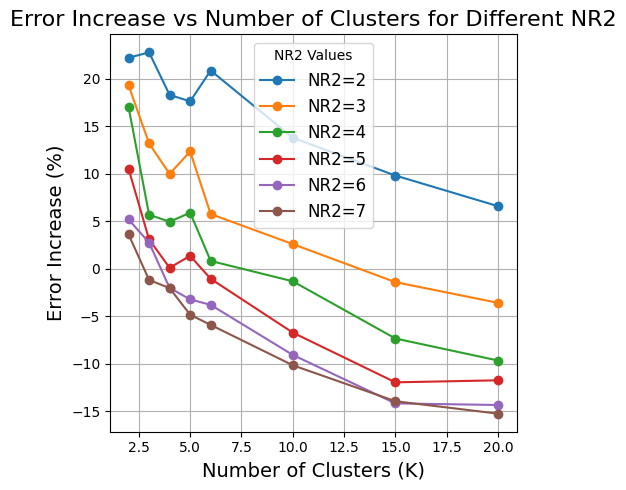

In [7]:
import matplotlib.pyplot as plt

# Initialize an array to store error increases
error_increases = {}

# Second pass: Calculate and store the differences
for city in cities:
    for random_flag in random_flags:
        for nr2 in nr2_values:
            data_key = (city, random_flag, nr2)
            total_costs_miMo_retrained = data[data_key]['total_costs_miMo_retrained']
            total_costs_original = data[data_key]['total_costs_original']
            total_costs_miMo = data[data_key]['total_costs_miMo']
            
            # Initialize a dictionary to store error increases for each nr2 value
            if nr2 not in error_increases:
                error_increases[nr2] = []

            # Calculate the percentage improvement for each K
            for K in Ks:
                if K in total_costs_original and K in total_costs_miMo_retrained:
                    original_cost = total_costs_original[K]
                    miMo_enhanced_cost = total_costs_miMo_retrained[K]
                    
                    # Calculate the percentage increase
                    error_increase = ((miMo_enhanced_cost - original_cost) / original_cost) * 100
                    error_increases[nr2].append((K, error_increase))
                    # print(f"City: {city}, Random Flag: {random_flag}, NR2: {nr2}, K={K}: miMo_enhanced is {error_increase:.2f}% improved from original")

# Plotting the error increases
plt.figure(figsize=(5, 5))

# Iterate over each nr2 value and plot the corresponding error increases for different K values
for nr2, error_data in error_increases.items():
    Ks_values = [K for K, _ in error_data]
    error_increase_values = [error_increase for _, error_increase in error_data]
    
    # Plot the line for each nr2 value
    plt.plot(Ks_values, error_increase_values, marker='o', linestyle='-', label=f'NR2={nr2}')

# Configure plot labels and legend
plt.xlabel('Number of Clusters (K)', fontsize=14)
plt.ylabel('Error Increase (%)', fontsize=14)
plt.title('Error Increase vs Number of Clusters for Different NR2', fontsize=16)
plt.legend(title='NR2 Values', fontsize=12)
plt.grid(True)

# Save and show the plot
plt.tight_layout()
# plt.savefig('error_increase_plot.pdf', bbox_inches='tight')
plt.show()
